### **<span style = 'color:#CCFFFF'>Applied FP algorithm to Associate Rules  </span>**

- **Bài toán**: \
Cửa hàng tạp hóa điện tử của Hunter là một thương hiệu nổi tiếng về phong cách sống thế hệ mới đang phát triển. E's Hunter có sự hiện diện của thương hiệu tại 10 quận và luôn tìm kiếm những cách mới để cải thiện và dự đoán nhu cầu của khách hàng. Các sự kiện thiên nga đen như Covid-19, chiến tranh Ukraine, tình trạng thiếu gas chắc chắn đã ảnh hưởng đến cách khách hàng mua sắm tại cửa hàng của chúng tôi. Đề xuất giá trị kinh doanh cho việc ra quyết định dựa trên thông tin.

- **Đề xuất**: Sử dụng phương pháp Data mining để tìm ra các sản phẩm có thể bán chéo cùng nhau để tăng `promotion`


### **<span style = 'color:#CCFFFF'>Phương pháp đo lường </span>**

#### **Support**
Là tần suất giao dịch mua toàn bộ item của bộ X và Y

$$
\begin{equation*}
support(X\rightarrow{Y}) = \frac{\text{Tổng số giao dịch mua X và Y}}{\text{Tổng số giao dịch}}
\end{equation*}
$$

#### **Confidence**
Là xác suất khi giao dịch đó có X thì sẽ có thêm Y

$$
\begin{equation*}
confidence(X\rightarrow{Y}) = \frac{\text{TTổng số giao dịch mua X và Y}}{\text{Tổng số giao dịch mua X}}
\end{equation*}
$$

#### **Lift**
Hệ số so sánh khi khách hàng đó mua X, khả năng mua Y có độ lớn ra sao

$$
\begin{equation*}
lift(X\rightarrow{Y}) = \frac{Confidence(X\rightarrow{Y})}{Support(Y)}
\end{equation*}
$$


#### **Thuật toán FP growth**
Thuật toán này dựa trên phương pháp phân nhánh `sơ đồ cây` và theo các bước:
1. Quét cơ sở dữ liệu một lần, tìm các tập phổ biến `1-itemsets` (chỉ có một hạng mục hay phần tử).
2. Sắp xếp các tập phổ biến tìm được theo thứ tự `giảm dần` của độ phổ biến (tần số).
3. Quét lại cơ sở dữ liệu lần 2, `xây dựng một cây FP-tree` bắt đầu với hạng mục `phổ biến nhất` trong mỗi giao dịch.
4. Xây dựng `cây điều kiện FP` dựa trên cơ sở mẫu điều kiện đối với các items cho tới khi thu được mẫu phổ biến


#### **Thuật toán Cosine Similarity**
Cosine similarity đo lường tính `tương đồng` giữa 2 dataset dựa trên góc tạo bởi hướng vectơ của chúng trong không gian theo công thức `cos(θ) = A · B/ ∥A∥∥B∥`


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.display.max_rows = 400
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.3f}'.format 
pd.set_option('display.max_colwidth', 1)

import warnings
warnings.filterwarnings("ignore")

**Bộ dữ liệu**

Dữ liệu bao gồm thông tin các giao dịch bao gồm orders - số lượng order - tần suất orders - mặt hàng.
Tuy nhiên target của chúng ta sẽ tập trung vào việc những `mặt hàng` nào `xuất hiện thường xuyên` cùng nhau trong các `transactions`

In [2]:
# Dataset
df = pd.read_csv(r'E:\Associate RUles\ECommerce_consumer behaviour\ECommerce_consumer behaviour.csv')
df.head(10)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables
5,2425083,49125,1,2,18,NaN,91,6,0,16,dairy eggs,soy lactosefree
6,2425083,49125,1,2,18,NaN,120,7,0,16,dairy eggs,yogurt
7,2425083,49125,1,2,18,NaN,59,8,0,15,canned goods,canned meals beans
8,2425083,49125,1,2,18,NaN,35,9,0,12,meat seafood,poultry counter
9,1944304,162867,1,3,17,NaN,37,1,0,1,frozen,ice cream ice


In [3]:
# Kiểm tra các dữ liệu khuyết thiếu
df.isnull().sum()/df.shape[0]

order_id                 0.000
user_id                  0.000
order_number             0.000
order_dow                0.000
order_hour_of_day        0.000
days_since_prior_order   0.062
product_id               0.000
add_to_cart_order        0.000
reordered                0.000
department_id            0.000
department               0.000
product_name             0.000
dtype: float64

Ta cần nhóm dữ liệu vào để tạo ra `output` có các features là các hàng hóa được order nhận đầu vào là `True` nếu `được order` và `False` trong trường hợp còn lại -- với mỗi dòng là một transaction

In [4]:
df2 = df.groupby(['order_id'])['product_name'].apply(lambda group_series: group_series.tolist()).reset_index()
df2 = df2['product_name'].values.tolist()

# Danh sách các order 
data = list(filter(lambda x: len(x) > 2, df2))

In [5]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(data).transform(data)
df_transaction_Encoder   = pd.DataFrame(te_array, columns=te.columns_)
df_transaction_Encoder.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False

In [6]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding
df_encoder = pd.DataFrame()
for i in list(df_transaction_Encoder.columns):
  df_encoder[i] = LabelEncoder().fit_transform(df_transaction_Encoder[i])

df_encoder

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Ta cũng cần xem xét mức đóng góp của các `hàng hóa` trong các giao dịch được ghi lại, nhằm loại bỏ đi các items `không phổ biến`. `Không phổ biến` đồng nghĩa với `số các kết hợp có thể tạo ra đối với các item khác` là rất ít và không có ý nghĩa để recommend

In [7]:
# Ở đây từ df_encoder, mình muốn biết thêm về số lượng item được order trong khoảng thời gian trên
item = list(df_encoder)
orders_per_item = [len(df_encoder[df_encoder[i]== 1]) for i in item]
not_orders_per_item = [len(df_encoder[df_encoder[i]== 0]) for i in item]

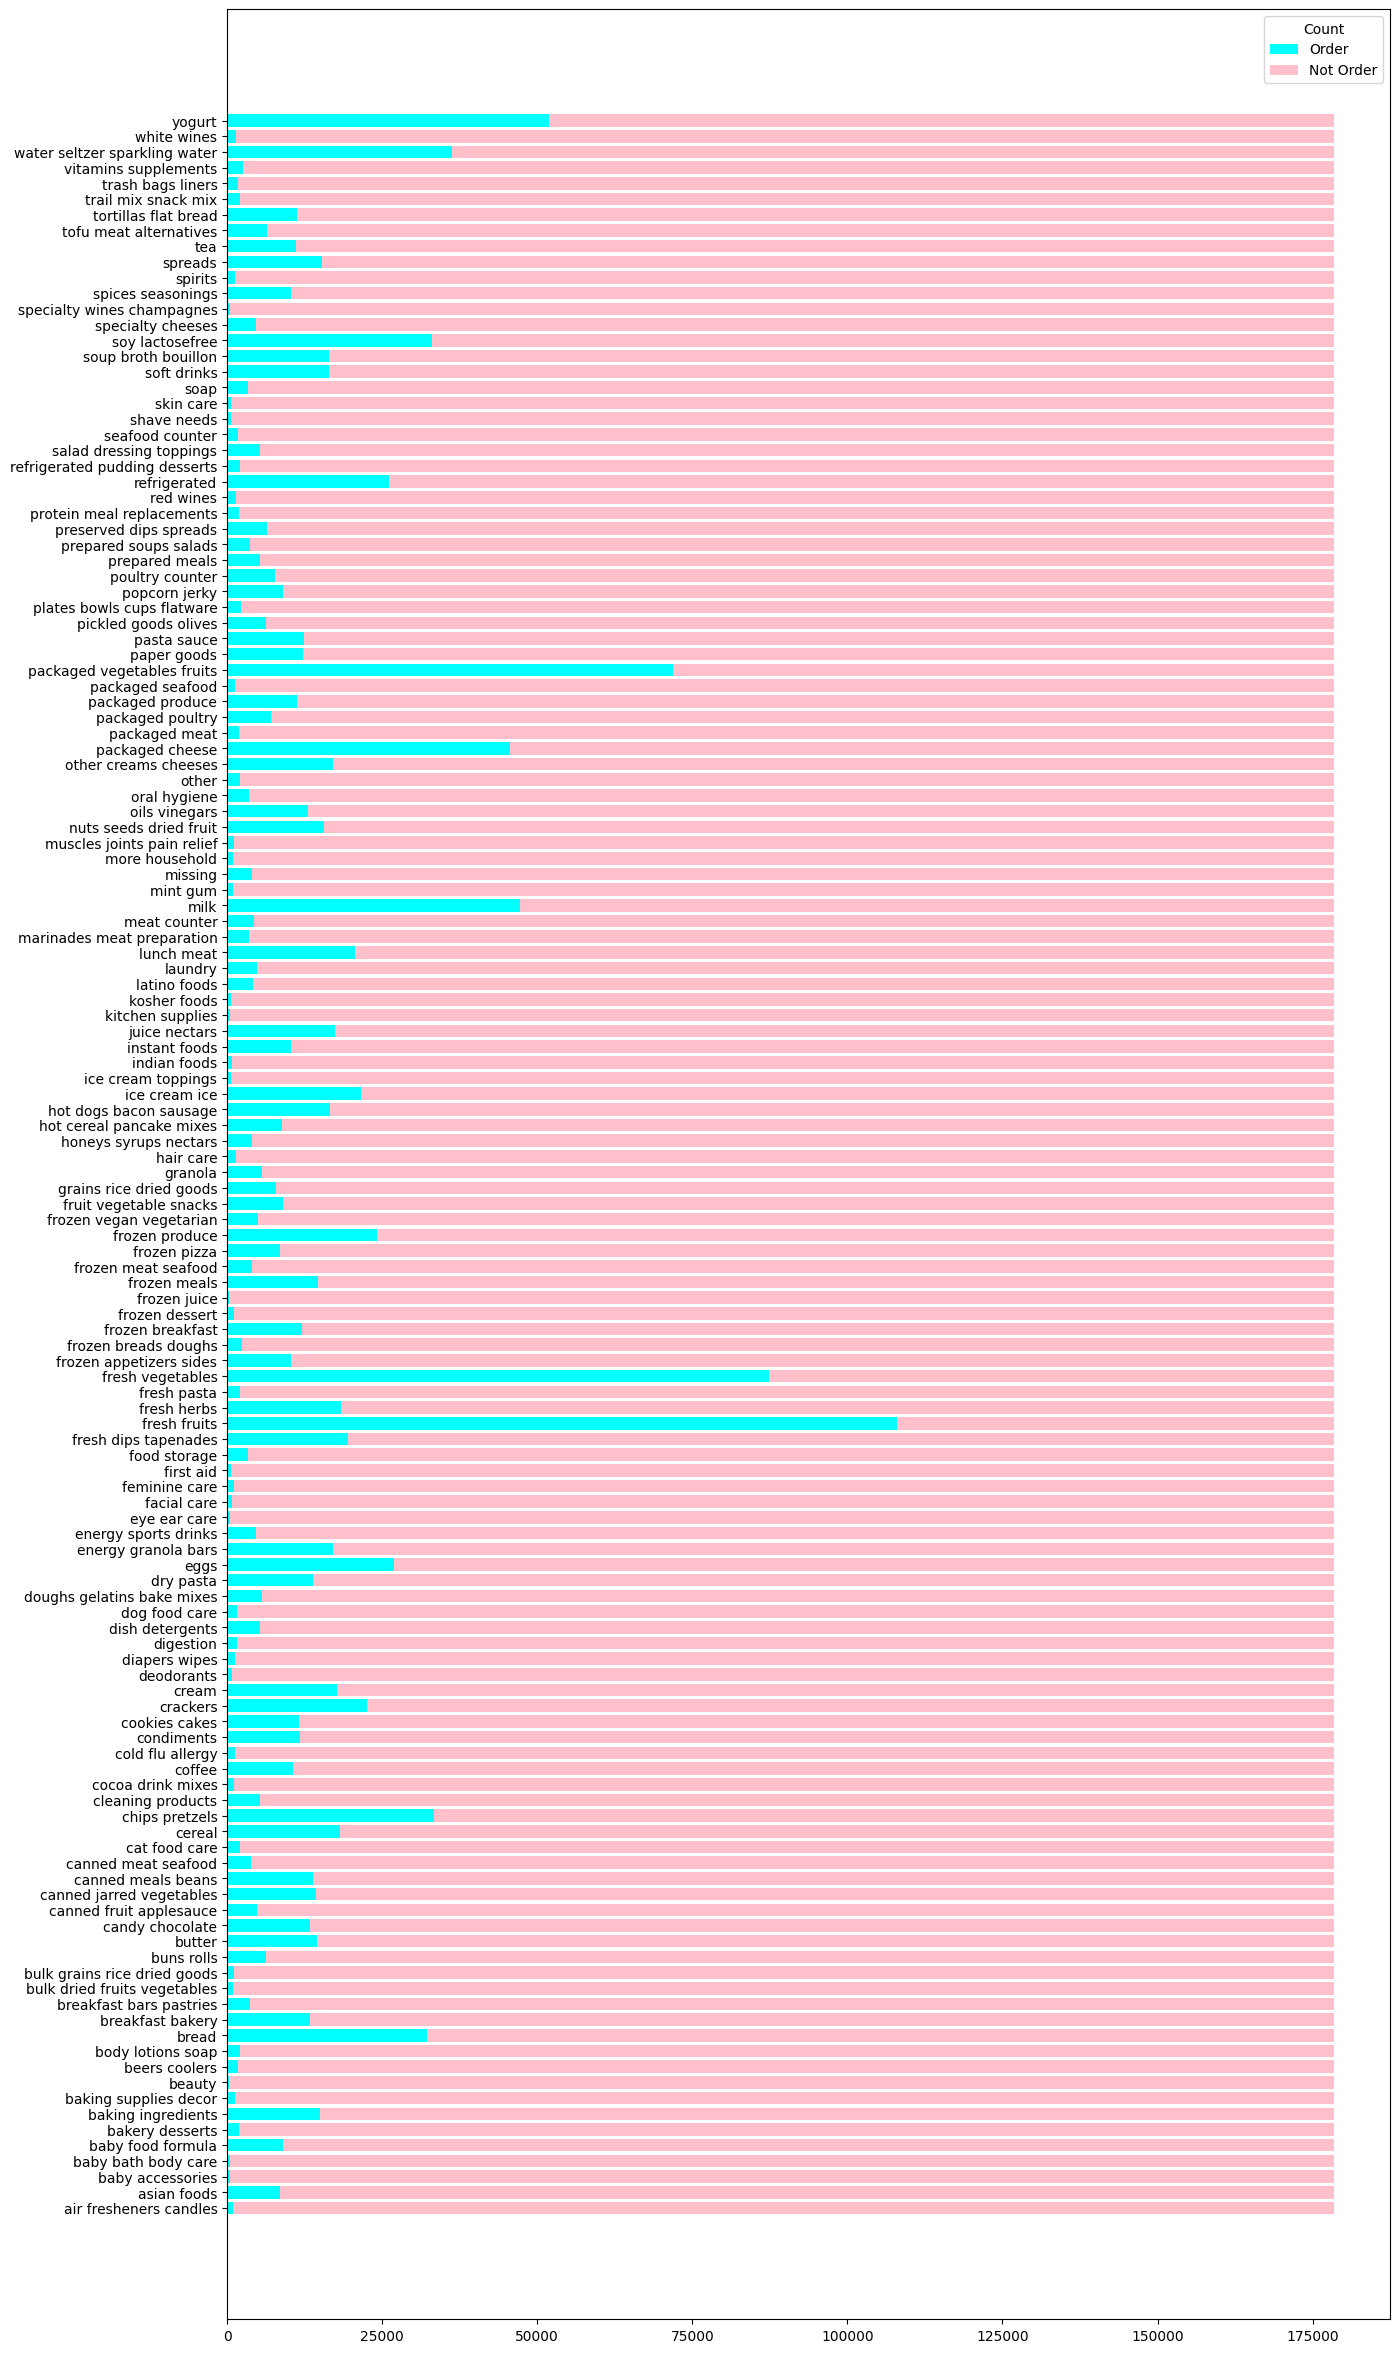

In [8]:

plt.figure(figsize = (15,30))
ax1 = plt.barh(item, orders_per_item, color="cyan")
ax2 = plt.barh(item, not_orders_per_item, left= orders_per_item, color="pink")

plt.legend([ax1, ax2], ['Order', 'Not Order'], title="Count", loc="upper right")
plt.show()

In [9]:
# Mình cần loại bỏ những item có số lượng đặt hàng ít
# Giả sử những item có số lượng xuất hiện trong mỗi giao dịch từ 10% trở xuống --> được coi là infrequent items - những item không phổ biến
threshold = (10/100)*len(df_encoder)

# Những item không phổ biến
infrequent_item = pd.DataFrame(orders_per_item)[pd.DataFrame(orders_per_item)[0]< threshold]

list_infrequent = []
for i in list(infrequent_item.index):
    if item[i] in item:
        list_infrequent.append(item[i])

df_cosine = df_encoder.copy()
df_cosine = df_cosine.drop(list_infrequent, axis = 1)
# Loại bỏ những item khỏi bộ dữ liệu
df_encoder = df_transaction_Encoder.drop(list_infrequent, axis = 1)

In [10]:
from numpy.linalg import norm

result_cosine = pd.DataFrame()
for i in list(df_cosine.columns):
    for j in list(df_cosine.columns):
        if i != j:
            A = np.array(df_cosine[i])
            B = np.array(df_cosine[j])
            result = np.dot(A,B)/(norm(A)*norm(B))

            dictionary = pd.DataFrame({'First Item': [i], 'Second Item':[j], 'cosine_simi': [result]})
            result_cosine = pd.concat([result_cosine, dictionary], ignore_index = True).sort_values(by = 'cosine_simi', ascending = False)


result_cosine.head(20)

,First Item,Second Item,cosine_simi
0,fresh fruits,fresh vegetables,0.652
1,fresh vegetables,fresh fruits,0.652
2,packaged vegetables fruits,fresh fruits,0.611
3,fresh fruits,packaged vegetables fruits,0.611
4,packaged vegetables fruits,fresh vegetables,0.591
5,fresh vegetables,packaged vegetables fruits,0.591
6,yogurt,fresh fruits,0.502
7,fresh fruits,yogurt,0.502
8,fresh fruits,milk,0.459
9,milk,fresh fruits,0.459


In [11]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

#### Số lượng quy tắc bán chéo theo Confidence và Support

In [12]:
min_confidence_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
min_support_list =[0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
rule = pd.DataFrame()
for i in min_support_list:
    for j in min_confidence_list:
        fp_result = fpgrowth(df_encoder, min_support = i, use_colnames=True)
        #fp_result['length'] = fp_result['itemsets'].apply(lambda x: len(x))
    
        rules = association_rules(fp_result, metric='confidence', min_threshold= j)
        #rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
        number_of_rules= len(rules)

        rules_by_support = pd.DataFrame(dict({'support': [i],'num_rules': [number_of_rules], 'confidence':[j]}))
        rule = pd.concat([rule, rules_by_support], ignore_index = True)

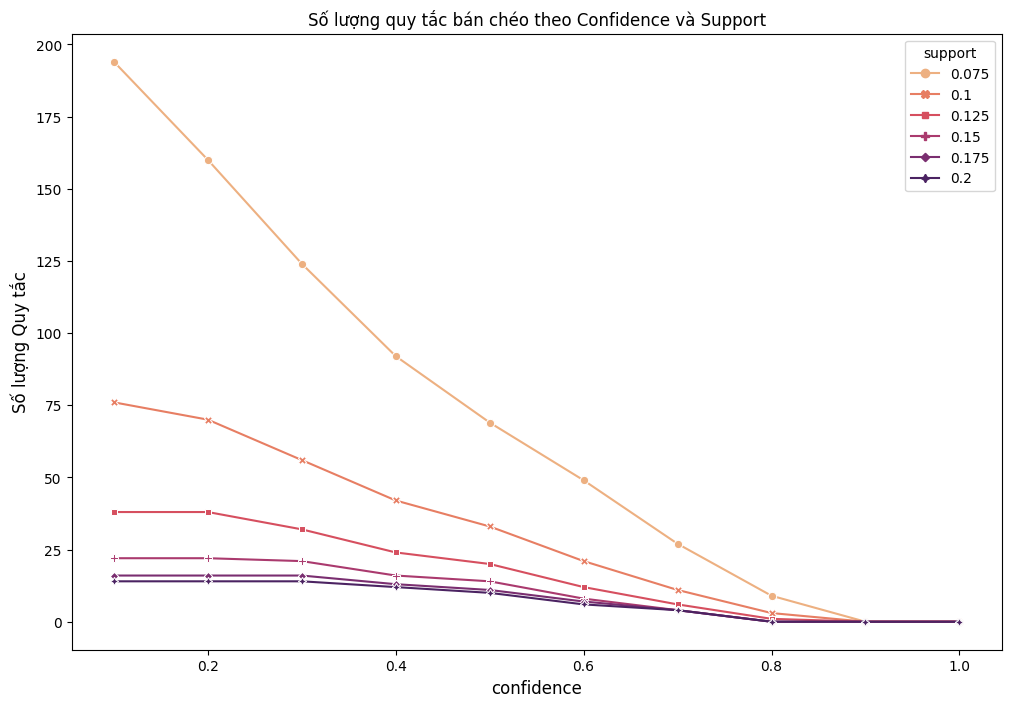

In [13]:
plt.figure(figsize = (12,8))
sns.lineplot(data =rule,x='confidence', y ='num_rules', hue ='support',
            style ='support', markers =True, dashes =False, palette = 'flare',)
plt.title('Số lượng quy tắc bán chéo theo Confidence và Support', fontsize = 12)
plt.xlabel('confidence', fontsize = 12)
plt.ylabel('Số lượng Quy tắc', fontsize=12)
plt.show()
pass

#### Số khách hàng lớn nhất được áp dụng Associate Rules theo Confidence và Support

In [14]:
transaction_total = df_encoder.shape[0]
min_confidence_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
min_support_list =[0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
rule2 = pd.DataFrame()
for i in min_support_list:
    for j in min_confidence_list:
        fp_result = fpgrowth(df_encoder, min_support = i, use_colnames=True)
        #fp_result['length'] = fp_result['itemsets'].apply(lambda x: len(x))
    
        rules = association_rules(fp_result, metric='confidence', min_threshold= j)
        #rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
        max_transaction = max(rules['confidence'],default = 0)* transaction_total

        rules_by_transaction = pd.DataFrame(dict({'support': [i],'num_trans': [max_transaction], 'confidence':[j]}))
        rule2 = pd.concat([rule2, rules_by_transaction], ignore_index = True)

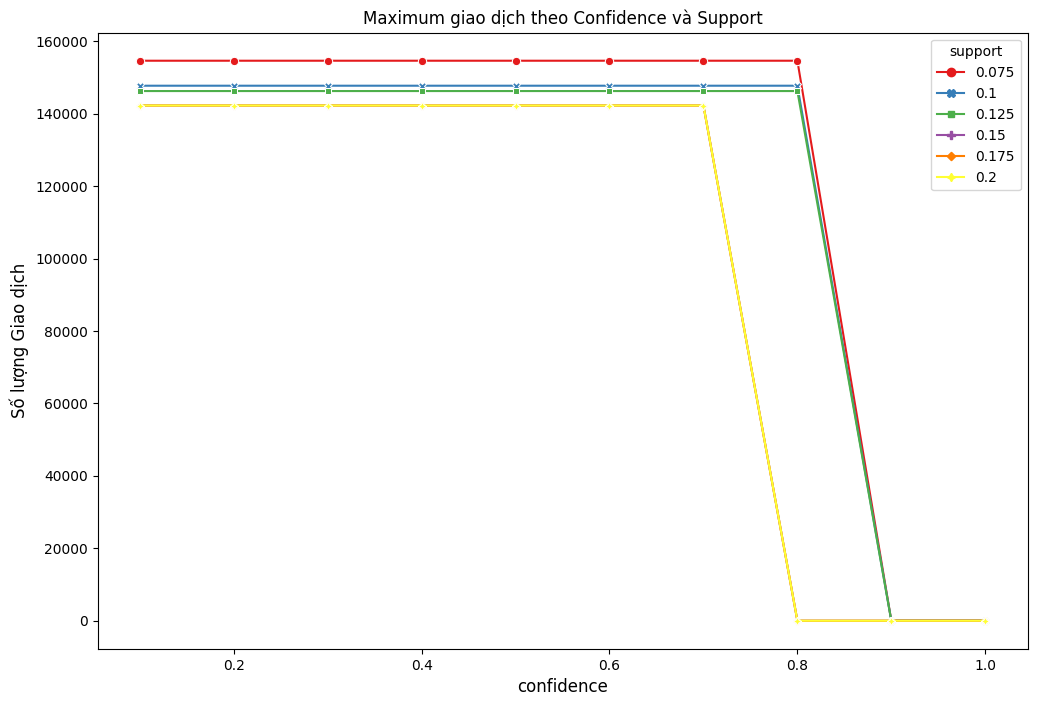

In [43]:
plt.figure(figsize = (12,8))
sns.lineplot(data =rule2,x='confidence', y ='num_trans', hue ='support',
            style ='support', markers =True, dashes =False, palette = 'Set1',)
plt.title('Maximum giao dịch theo Confidence và Support', fontsize = 12)
plt.xlabel('confidence', fontsize = 12)
plt.ylabel('Số lượng Giao dịch', fontsize=12)
plt.show()
pass

### **<span style = 'color:#CCFFFF'> Phân tích kết quả </span>**
- **Số lượng quy tắc**
    - Mức support tối thiểu `0.075` \
    Có 69 cách kết hợp tại min_confidence 0.5 và 27 đối với min_confidence = 0.7
    - Mức support tối thiểu `0.1` \
    Có 33 cách kết hợp tại min_confidence 0.5 và 11 đối với min_confidence = 0.7 
    - Mức support tối thiểu `0.125`    \
    Có 20 cách kết hợp tại min_confidence 0.5 và 6 đối với min_confidence = 0.7 
    
    - Mức support tối thiểu `0.15` \
    Có 14 cách kết hợp tại min_confidence 0.5 và 4 đối với min_confidence = 0.7 

    - Mức support tối thiểu `0.175 và 0.2`
    Có [11,10] cách kết hợp tại min_confidence 0.5 và 4 đối với min_confidence = 0.7 


    Ở mức support tối thiểu `0.075`, chúng ta lấy được nhiều cách kết hợp, đủ để tạo ra các cách kết hợp ngẫu nhiên và mức support cao nhất `0.2`, chúng ta lọc được các điều kiện cần quan tâm nhất. \Tuy nhiên có thể xem xét áp dụng mức support tối thiểu bằng `0.125`, số lượng kết hợp có thể áp dụng với nhiều mặt hàng

- **Số lượng khách hàng**
    Target của chúng ta sẽ là số lượng khách hàng áp dụng luật kết hợp nhiều nhất có thể. Khi  mức min_confidence `vượt quá 0.7`, số khách hàng tối đa với mỗi mức kết hợp giảm nghiêm trọng. 

In [42]:
fp_result = fpgrowth(df_encoder, min_support = 0.175, use_colnames=True)
rules = association_rules(fp_result, metric='confidence', min_threshold= 0.5)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.sort_values(by ='confidence', ascending=  False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
7,"(packaged vegetables fruits, fresh vegetables)",(fresh fruits),0.262,0.605,0.209,0.797,1.317,0.050,1.946,0.327,2
6,(packaged vegetables fruits),(fresh fruits),0.402,0.605,0.301,0.749,1.238,0.058,1.573,0.321,1
0,(fresh vegetables),(fresh fruits),0.489,0.605,0.355,0.726,1.199,0.059,1.439,0.325,1
2,(yogurt),(fresh fruits),0.291,0.605,0.210,0.724,1.196,0.034,1.429,0.231,1
3,(milk),(fresh fruits),0.264,0.605,0.183,0.694,1.147,0.023,1.290,0.174,1
8,"(packaged vegetables fruits, fresh fruits)",(fresh vegetables),0.301,0.489,0.209,0.694,1.419,0.062,1.668,0.422,2
4,(packaged vegetables fruits),(fresh vegetables),0.402,0.489,0.262,0.652,1.333,0.065,1.467,0.418,1
9,"(fresh vegetables, fresh fruits)",(packaged vegetables fruits),0.355,0.402,0.209,0.589,1.464,0.066,1.455,0.491,2
1,(fresh fruits),(fresh vegetables),0.605,0.489,0.355,0.586,1.199,0.059,1.235,0.420,1
5,(fresh vegetables),(packaged vegetables fruits),0.489,0.402,0.262,0.536,1.333,0.065,1.289,0.489,1


- **Đánh giá** :
    - Khi càng tăng mức support, số lượng item trong cùng 1 giỏ thuộc nhóm nguyên nhân để có 1 item nhóm kết quả sẽ càng giảm

    - Khi so sánh với hệ số tương đồng `cosine similarity` với 20 cách kết hợp `1-1` đã tính từ trước, mức support càng tăng thì đề xuất của 2 phương pháp càng có sự giống nhau về thứ tự đề xuất


- **Đề xuất**
    - Đối với những khách hàng `phổ thông`, ta có thể sử dụng các cách kết hợp lấy mức support tối thiểu là `0.075` để có đa dạng hàng hóa và sự lựa chọn
    
    - Đối với những khách hàng có tần suất `mua lớn hoặc thường xuyên`, luật kết hợp nên chặt chẽ `(min_supp ~ 0.2)`
    